In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
import pennylane as qml
import numpy as np
from pennylane.templates import RandomLayers

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, trange

/usr/local/anaconda3/envs/qml/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Quantum Convolutional Circuit

In [4]:
kernel_2_dev = qml.device("default.qubit", wires=4)
    
@qml.qnode(kernel_2_dev, interface="torch")
def kernel_2_circuit(phi, rand_params):

    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

### Output has same size as input: used in experiments 1-3

In [15]:
class QUANV2(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, image, params):
        """Convolves the input image with many applications of the same quantum circuit."""
        ## image.shape: (B, 1, 28, 28)
        out = torch.zeros(image.shape)

        for i in range(image.shape[0]):
            # Loop over the coordinates of the top-left pixel of 2x2 squares
            for j in range(0, 28, 2):
                for k in range(0, 28, 2):
                    # Process a squared 2x2 region of the image with a quantum circuit
                    subregion = [
                            image[i, 0, j, k],
                            image[i, 0, j, k + 1],
                            image[i, 0, j + 1, k],
                            image[i, 0, j + 1, k + 1]
                        ]
                    q_results = kernel_2_circuit(
                        subregion,
                        params # 4 random parameters
                    )

                    # Assign expectation values to different channels of the output pixel (j/2, k/2)
                    out[i, 0, j, k] = q_results[0]
                    out[i, 0, j, k + 1] = q_results[1]
                    out[i, 0, j + 1, k] = q_results[2]
                    out[i, 0, j + 1, k + 1] = q_results[3]
        
        return out

### Output has 4 channels for the Z expectation measurements: used in experiment 4

In [16]:
class QUANV2_orig(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, image, params):
        """Convolves the input image with many applications of the same quantum circuit."""
        ## image.shape: (B, 1, 28, 28)
        B = image.shape[0]
        out = torch.zeros((B, 4, 14, 14))

        for i in range(B):
            # Loop over the coordinates of the top-left pixel of 2x2 squares
            for j in range(0, 28, 2):
                for k in range(0, 28, 2):
                    # Process a squared 2x2 region of the image with a quantum circuit
                    subregion = [
                            image[i, 0, j, k],
                            image[i, 0, j, k + 1],
                            image[i, 0, j + 1, k],
                            image[i, 0, j + 1, k + 1]
                        ]
                    q_results = kernel_2_circuit(
                        subregion,
                        params # 4 random parameters
                    )

                    # Assign expectation values to different channels of the output pixel (j/2, k/2)
                    for c in range(4):
                        out[i, c, j // 2, k // 2] = q_results[c]
        
        return out

## Baseline CNN

In [20]:
class NetV0(nn.Module):
    def __init__(self):
        super(NetV0, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, params):
        """
        torch.Size([64, 1, 28, 28])
        torch.Size([64, 32, 26, 26])
        torch.Size([64, 32, 26, 26])
        torch.Size([64, 64, 24, 24])
        torch.Size([64, 64, 24, 24])
        torch.Size([64, 64, 12, 12])
        torch.Size([64, 64, 12, 12])
        torch.Size([64, 9216])
        torch.Size([64, 128])
        torch.Size([64, 128])
        torch.Size([64, 128])
        torch.Size([64, 10])
        """

        # working cnn structure
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output


## Experiments
### 1: Quanv(x) + x

In [ ]:
class NetV1(nn.Module):
    def __init__(self):
        super(NetV1, self).__init__()
        self.quanv2 = QUANV2()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, params):
        qx = self.quanv2(x, params) # quanvolution
        x = x + qx # skip connection

        # working cnn structure
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output


### 2. Quanv(x) + Conv(x)

In [7]:
class NetV2(nn.Module):
    def __init__(self):
        super(NetV2, self).__init__()
        self.quanv2 = QUANV2()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

        # a layer to downsize the quanv output for the addition with middle layer output
        self.fc3 = nn.Linear(784, 128)

    def forward(self, x, params):
        qx = self.quanv2(x, params) # quanvolution
        qx = torch.flatten(qx, 1)
        qx = self.fc3(qx) 

        # working cnn structure
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        x = x + qx

        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

### 3. Concat(Quanv(x), x)

In [ ]:
class NetV3(nn.Module):
    def __init__(self):
        super(NetV3, self).__init__()
        self.quanv2 = QUANV2()
        self.conv1 = nn.Conv2d(2, 32, 3, 1) # changed from 1 32 3 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, params):
        qx = self.quanv2(x, params) # quanvolution
        x = torch.cat((x, qx), dim=1) # concatenate

        # working cnn structure
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

### 4. Concat(Quanv(x), Conv(x))

In [ ]:
class NetV4(nn.Module):
    def __init__(self):
        super(NetV4, self).__init__()
        self.quanv2 = QUANV2_orig() # changed from QUANV
        self.fcQ = nn.Linear(784, 128)

        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)

        self.fc2 = nn.Linear(256, 10) # changed from 128 10

    def forward(self, x, params):
        qx = self.quanv2(x, params) # quanvolution
        qx = torch.flatten(qx, 1)
        qx = self.fcQ(qx)

        # working cnn structure
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = torch.cat((x, qx), dim=1) # concatenate

        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

## Trains model in batches

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    params = np.random.uniform(high=2*np.pi, size=(1, 4))
    params_torch = torch.tensor(params, requires_grad=True)

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, params_torch)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 5 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    return params_torch


## Tests model

In [9]:
def test(model, device, test_loader, trained_params):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, trained_params)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    T = len(test_loader.dataset)
    accuracy = 100. * correct / T
    test_loss /= T

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, T, accuracy))
    
    return accuracy


## Subsets the data, chooses a model, and trains and tests the model on the data

In [18]:
def main(batch_size=64, subset_size=1000, num_epochs=14, save_model=True, sim=4):
    torch.manual_seed(1)

    device = torch.device("cpu")

    train_kwargs = {'batch_size': batch_size}
    test_kwargs = {'batch_size': 1000}

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    dataset1 = torch.utils.data.Subset(dataset1, list(range(subset_size)))
    dataset2 = torch.utils.data.Subset(dataset2, list(range(subset_size)))
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = None
    if sim == 0:
        model = NetV0().to(device)
    elif sim == 1:
        model = NetV1().to(device)
    elif sim == 2:
        model = NetV2().to(device)
    elif sim == 3:
        model = NetV3().to(device)
    elif sim == 4:
        model = NetV4().to(device)

    optimizer = optim.Adadelta(model.parameters(), lr=1.0)

    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    
    prev_accuracy = 0
    for epoch in trange(1, num_epochs + 1):
        trained_params = train(model, device, train_loader, optimizer, epoch)
        accuracy = test(model, device, test_loader, trained_params)
        if np.abs(prev_accuracy - accuracy) < 0.001:
            break
        prev_accuracy = accuracy
        scheduler.step()

#     accuracies = []
#     for epoch in trange(1, num_epochs + 1):
#         trained_params = train(model, device, train_loader, optimizer, epoch)
#         accuracy = test(model, device, test_loader, trained_params)
#         accuracies.append(accuracy)
#         prev_accuracy = accuracy
#         scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_qnn.pt")
    
    return accuracies

## CNN training

In [21]:
cnn_accuracies = main(batch_size=10, subset_size=1000, num_epochs=14, sim=0)

  0%|                                                    | 0/14 [00:00<?, ?it/s]

Train Epoch: 1 [0/1000 (0%)]	Loss: 2.328400
Train Epoch: 1 [50/1000 (5%)]	Loss: 2.222883
Train Epoch: 1 [100/1000 (10%)]	Loss: 1.816031
Train Epoch: 1 [150/1000 (15%)]	Loss: 1.600388
Train Epoch: 1 [200/1000 (20%)]	Loss: 1.083158
Train Epoch: 1 [250/1000 (25%)]	Loss: 1.698865
Train Epoch: 1 [300/1000 (30%)]	Loss: 0.833416
Train Epoch: 1 [350/1000 (35%)]	Loss: 0.657949
Train Epoch: 1 [400/1000 (40%)]	Loss: 0.391857
Train Epoch: 1 [450/1000 (45%)]	Loss: 0.376808
Train Epoch: 1 [500/1000 (50%)]	Loss: 1.870976
Train Epoch: 1 [550/1000 (55%)]	Loss: 0.822930
Train Epoch: 1 [600/1000 (60%)]	Loss: 0.717489
Train Epoch: 1 [650/1000 (65%)]	Loss: 0.175671
Train Epoch: 1 [700/1000 (70%)]	Loss: 0.733484
Train Epoch: 1 [750/1000 (75%)]	Loss: 0.539067
Train Epoch: 1 [800/1000 (80%)]	Loss: 0.349212
Train Epoch: 1 [850/1000 (85%)]	Loss: 1.537902
Train Epoch: 1 [900/1000 (90%)]	Loss: 0.565172
Train Epoch: 1 [950/1000 (95%)]	Loss: 0.131932


  7%|███▏                                        | 1/14 [00:02<00:30,  2.38s/it]


Test set: Average loss: 0.4075, Accuracy: 858/1000 (86%)

Train Epoch: 2 [0/1000 (0%)]	Loss: 0.453899
Train Epoch: 2 [50/1000 (5%)]	Loss: 0.644826
Train Epoch: 2 [100/1000 (10%)]	Loss: 0.409471
Train Epoch: 2 [150/1000 (15%)]	Loss: 0.289012
Train Epoch: 2 [200/1000 (20%)]	Loss: 0.151460
Train Epoch: 2 [250/1000 (25%)]	Loss: 0.894029
Train Epoch: 2 [300/1000 (30%)]	Loss: 0.436587
Train Epoch: 2 [350/1000 (35%)]	Loss: 0.452869
Train Epoch: 2 [400/1000 (40%)]	Loss: 0.042302
Train Epoch: 2 [450/1000 (45%)]	Loss: 0.277274
Train Epoch: 2 [500/1000 (50%)]	Loss: 0.916007
Train Epoch: 2 [550/1000 (55%)]	Loss: 0.084703
Train Epoch: 2 [600/1000 (60%)]	Loss: 0.119108
Train Epoch: 2 [650/1000 (65%)]	Loss: 0.037132
Train Epoch: 2 [700/1000 (70%)]	Loss: 0.249902
Train Epoch: 2 [750/1000 (75%)]	Loss: 0.028713
Train Epoch: 2 [800/1000 (80%)]	Loss: 0.331998
Train Epoch: 2 [850/1000 (85%)]	Loss: 1.840283
Train Epoch: 2 [900/1000 (90%)]	Loss: 1.189526
Train Epoch: 2 [950/1000 (95%)]	Loss: 0.031427


 14%|██████▎                                     | 2/14 [00:04<00:29,  2.49s/it]


Test set: Average loss: 0.2725, Accuracy: 911/1000 (91%)

Train Epoch: 3 [0/1000 (0%)]	Loss: 0.071403
Train Epoch: 3 [50/1000 (5%)]	Loss: 0.351339
Train Epoch: 3 [100/1000 (10%)]	Loss: 0.396665
Train Epoch: 3 [150/1000 (15%)]	Loss: 0.124557
Train Epoch: 3 [200/1000 (20%)]	Loss: 0.047747
Train Epoch: 3 [250/1000 (25%)]	Loss: 0.111218
Train Epoch: 3 [300/1000 (30%)]	Loss: 0.294856
Train Epoch: 3 [350/1000 (35%)]	Loss: 0.095717
Train Epoch: 3 [400/1000 (40%)]	Loss: 0.092732
Train Epoch: 3 [450/1000 (45%)]	Loss: 0.181141
Train Epoch: 3 [500/1000 (50%)]	Loss: 1.200132
Train Epoch: 3 [550/1000 (55%)]	Loss: 0.133978
Train Epoch: 3 [600/1000 (60%)]	Loss: 0.145312
Train Epoch: 3 [650/1000 (65%)]	Loss: 0.090092
Train Epoch: 3 [700/1000 (70%)]	Loss: 0.297203
Train Epoch: 3 [750/1000 (75%)]	Loss: 0.090966
Train Epoch: 3 [800/1000 (80%)]	Loss: 0.004771
Train Epoch: 3 [850/1000 (85%)]	Loss: 0.983404
Train Epoch: 3 [900/1000 (90%)]	Loss: 1.017979
Train Epoch: 3 [950/1000 (95%)]	Loss: 0.044346


 21%|█████████▍                                  | 3/14 [00:06<00:25,  2.28s/it]


Test set: Average loss: 0.2246, Accuracy: 926/1000 (93%)

Train Epoch: 4 [0/1000 (0%)]	Loss: 0.025411
Train Epoch: 4 [50/1000 (5%)]	Loss: 0.248930
Train Epoch: 4 [100/1000 (10%)]	Loss: 0.359774
Train Epoch: 4 [150/1000 (15%)]	Loss: 0.194972
Train Epoch: 4 [200/1000 (20%)]	Loss: 0.237975
Train Epoch: 4 [250/1000 (25%)]	Loss: 0.162805
Train Epoch: 4 [300/1000 (30%)]	Loss: 0.099579
Train Epoch: 4 [350/1000 (35%)]	Loss: 0.064067
Train Epoch: 4 [400/1000 (40%)]	Loss: 0.062275
Train Epoch: 4 [450/1000 (45%)]	Loss: 0.017167
Train Epoch: 4 [500/1000 (50%)]	Loss: 0.680619
Train Epoch: 4 [550/1000 (55%)]	Loss: 0.022255
Train Epoch: 4 [600/1000 (60%)]	Loss: 0.058145
Train Epoch: 4 [650/1000 (65%)]	Loss: 0.006144
Train Epoch: 4 [700/1000 (70%)]	Loss: 0.116816
Train Epoch: 4 [750/1000 (75%)]	Loss: 0.007942
Train Epoch: 4 [800/1000 (80%)]	Loss: 0.014144
Train Epoch: 4 [850/1000 (85%)]	Loss: 0.926559
Train Epoch: 4 [900/1000 (90%)]	Loss: 0.797513
Train Epoch: 4 [950/1000 (95%)]	Loss: 0.315560


 29%|████████████▌                               | 4/14 [00:09<00:22,  2.22s/it]


Test set: Average loss: 0.2207, Accuracy: 927/1000 (93%)

Train Epoch: 5 [0/1000 (0%)]	Loss: 0.024061
Train Epoch: 5 [50/1000 (5%)]	Loss: 0.052036
Train Epoch: 5 [100/1000 (10%)]	Loss: 0.079567
Train Epoch: 5 [150/1000 (15%)]	Loss: 0.070655
Train Epoch: 5 [200/1000 (20%)]	Loss: 0.115007
Train Epoch: 5 [250/1000 (25%)]	Loss: 0.050440
Train Epoch: 5 [300/1000 (30%)]	Loss: 0.264646
Train Epoch: 5 [350/1000 (35%)]	Loss: 0.195619
Train Epoch: 5 [400/1000 (40%)]	Loss: 0.172634
Train Epoch: 5 [450/1000 (45%)]	Loss: 0.005826
Train Epoch: 5 [500/1000 (50%)]	Loss: 0.114988
Train Epoch: 5 [550/1000 (55%)]	Loss: 0.015782
Train Epoch: 5 [600/1000 (60%)]	Loss: 0.028229
Train Epoch: 5 [650/1000 (65%)]	Loss: 0.041435
Train Epoch: 5 [700/1000 (70%)]	Loss: 0.013106
Train Epoch: 5 [750/1000 (75%)]	Loss: 0.016658
Train Epoch: 5 [800/1000 (80%)]	Loss: 0.005876
Train Epoch: 5 [850/1000 (85%)]	Loss: 1.485664
Train Epoch: 5 [900/1000 (90%)]	Loss: 1.533884
Train Epoch: 5 [950/1000 (95%)]	Loss: 0.044571


 36%|███████████████▋                            | 5/14 [00:11<00:19,  2.18s/it]


Test set: Average loss: 0.2228, Accuracy: 928/1000 (93%)

Train Epoch: 6 [0/1000 (0%)]	Loss: 0.047223
Train Epoch: 6 [50/1000 (5%)]	Loss: 0.028410
Train Epoch: 6 [100/1000 (10%)]	Loss: 0.155864
Train Epoch: 6 [150/1000 (15%)]	Loss: 0.114088
Train Epoch: 6 [200/1000 (20%)]	Loss: 0.040131
Train Epoch: 6 [250/1000 (25%)]	Loss: 0.253563
Train Epoch: 6 [300/1000 (30%)]	Loss: 0.135327
Train Epoch: 6 [350/1000 (35%)]	Loss: 0.162893
Train Epoch: 6 [400/1000 (40%)]	Loss: 0.643886
Train Epoch: 6 [450/1000 (45%)]	Loss: 0.150918
Train Epoch: 6 [500/1000 (50%)]	Loss: 0.866864
Train Epoch: 6 [550/1000 (55%)]	Loss: 0.003567
Train Epoch: 6 [600/1000 (60%)]	Loss: 0.039754
Train Epoch: 6 [650/1000 (65%)]	Loss: 0.021129
Train Epoch: 6 [700/1000 (70%)]	Loss: 0.011284
Train Epoch: 6 [750/1000 (75%)]	Loss: 0.002465
Train Epoch: 6 [800/1000 (80%)]	Loss: 0.005719
Train Epoch: 6 [850/1000 (85%)]	Loss: 0.488493
Train Epoch: 6 [900/1000 (90%)]	Loss: 1.335531
Train Epoch: 6 [950/1000 (95%)]	Loss: 0.103405


 43%|██████████████████▊                         | 6/14 [00:13<00:17,  2.21s/it]


Test set: Average loss: 0.2089, Accuracy: 933/1000 (93%)

Train Epoch: 7 [0/1000 (0%)]	Loss: 0.008467
Train Epoch: 7 [50/1000 (5%)]	Loss: 0.061015
Train Epoch: 7 [100/1000 (10%)]	Loss: 0.016770
Train Epoch: 7 [150/1000 (15%)]	Loss: 0.071333
Train Epoch: 7 [200/1000 (20%)]	Loss: 0.001286
Train Epoch: 7 [250/1000 (25%)]	Loss: 0.069378
Train Epoch: 7 [300/1000 (30%)]	Loss: 0.169604
Train Epoch: 7 [350/1000 (35%)]	Loss: 0.308108
Train Epoch: 7 [400/1000 (40%)]	Loss: 0.282292
Train Epoch: 7 [450/1000 (45%)]	Loss: 0.016442
Train Epoch: 7 [500/1000 (50%)]	Loss: 0.379546
Train Epoch: 7 [550/1000 (55%)]	Loss: 0.048926
Train Epoch: 7 [600/1000 (60%)]	Loss: 0.018385
Train Epoch: 7 [650/1000 (65%)]	Loss: 0.008421
Train Epoch: 7 [700/1000 (70%)]	Loss: 0.008493
Train Epoch: 7 [750/1000 (75%)]	Loss: 0.021450
Train Epoch: 7 [800/1000 (80%)]	Loss: 0.008802
Train Epoch: 7 [850/1000 (85%)]	Loss: 1.136832
Train Epoch: 7 [900/1000 (90%)]	Loss: 0.992630
Train Epoch: 7 [950/1000 (95%)]	Loss: 0.049398


 50%|██████████████████████                      | 7/14 [00:15<00:15,  2.15s/it]


Test set: Average loss: 0.2042, Accuracy: 929/1000 (93%)

Train Epoch: 8 [0/1000 (0%)]	Loss: 0.007993
Train Epoch: 8 [50/1000 (5%)]	Loss: 0.086725
Train Epoch: 8 [100/1000 (10%)]	Loss: 0.352239
Train Epoch: 8 [150/1000 (15%)]	Loss: 0.131822
Train Epoch: 8 [200/1000 (20%)]	Loss: 0.003484
Train Epoch: 8 [250/1000 (25%)]	Loss: 0.220900
Train Epoch: 8 [300/1000 (30%)]	Loss: 0.066973
Train Epoch: 8 [350/1000 (35%)]	Loss: 0.167371
Train Epoch: 8 [400/1000 (40%)]	Loss: 0.029891
Train Epoch: 8 [450/1000 (45%)]	Loss: 0.012106
Train Epoch: 8 [500/1000 (50%)]	Loss: 0.225893
Train Epoch: 8 [550/1000 (55%)]	Loss: 0.039802
Train Epoch: 8 [600/1000 (60%)]	Loss: 0.008964
Train Epoch: 8 [650/1000 (65%)]	Loss: 0.033784
Train Epoch: 8 [700/1000 (70%)]	Loss: 0.081580
Train Epoch: 8 [750/1000 (75%)]	Loss: 0.072189
Train Epoch: 8 [800/1000 (80%)]	Loss: 0.061418
Train Epoch: 8 [850/1000 (85%)]	Loss: 0.491679
Train Epoch: 8 [900/1000 (90%)]	Loss: 1.114273
Train Epoch: 8 [950/1000 (95%)]	Loss: 0.034975


 57%|█████████████████████████▏                  | 8/14 [00:17<00:13,  2.18s/it]


Test set: Average loss: 0.1970, Accuracy: 926/1000 (93%)

Train Epoch: 9 [0/1000 (0%)]	Loss: 0.020719
Train Epoch: 9 [50/1000 (5%)]	Loss: 0.006631
Train Epoch: 9 [100/1000 (10%)]	Loss: 0.023420
Train Epoch: 9 [150/1000 (15%)]	Loss: 0.103812
Train Epoch: 9 [200/1000 (20%)]	Loss: 0.002724
Train Epoch: 9 [250/1000 (25%)]	Loss: 0.019253
Train Epoch: 9 [300/1000 (30%)]	Loss: 0.035763
Train Epoch: 9 [350/1000 (35%)]	Loss: 0.003335
Train Epoch: 9 [400/1000 (40%)]	Loss: 0.004478
Train Epoch: 9 [450/1000 (45%)]	Loss: 0.012160
Train Epoch: 9 [500/1000 (50%)]	Loss: 0.144055
Train Epoch: 9 [550/1000 (55%)]	Loss: 0.027533
Train Epoch: 9 [600/1000 (60%)]	Loss: 0.009253
Train Epoch: 9 [650/1000 (65%)]	Loss: 0.004971
Train Epoch: 9 [700/1000 (70%)]	Loss: 0.040965
Train Epoch: 9 [750/1000 (75%)]	Loss: 0.025117
Train Epoch: 9 [800/1000 (80%)]	Loss: 0.008183
Train Epoch: 9 [850/1000 (85%)]	Loss: 0.601148
Train Epoch: 9 [900/1000 (90%)]	Loss: 1.285355
Train Epoch: 9 [950/1000 (95%)]	Loss: 0.001256


 64%|████████████████████████████▎               | 9/14 [00:19<00:10,  2.18s/it]


Test set: Average loss: 0.2026, Accuracy: 929/1000 (93%)

Train Epoch: 10 [0/1000 (0%)]	Loss: 0.002256
Train Epoch: 10 [50/1000 (5%)]	Loss: 0.121286
Train Epoch: 10 [100/1000 (10%)]	Loss: 0.184211
Train Epoch: 10 [150/1000 (15%)]	Loss: 0.050832
Train Epoch: 10 [200/1000 (20%)]	Loss: 0.002466
Train Epoch: 10 [250/1000 (25%)]	Loss: 0.003495
Train Epoch: 10 [300/1000 (30%)]	Loss: 0.188475
Train Epoch: 10 [350/1000 (35%)]	Loss: 0.032310
Train Epoch: 10 [400/1000 (40%)]	Loss: 0.012845
Train Epoch: 10 [450/1000 (45%)]	Loss: 0.078210
Train Epoch: 10 [500/1000 (50%)]	Loss: 0.074142
Train Epoch: 10 [550/1000 (55%)]	Loss: 0.005020
Train Epoch: 10 [600/1000 (60%)]	Loss: 0.032381
Train Epoch: 10 [650/1000 (65%)]	Loss: 0.036035
Train Epoch: 10 [700/1000 (70%)]	Loss: 0.020834
Train Epoch: 10 [750/1000 (75%)]	Loss: 0.006886
Train Epoch: 10 [800/1000 (80%)]	Loss: 0.004500
Train Epoch: 10 [850/1000 (85%)]	Loss: 0.394986
Train Epoch: 10 [900/1000 (90%)]	Loss: 0.629729
Train Epoch: 10 [950/1000 (95%)]	L

 71%|██████████████████████████████▋            | 10/14 [00:21<00:08,  2.13s/it]


Test set: Average loss: 0.2033, Accuracy: 928/1000 (93%)

Train Epoch: 11 [0/1000 (0%)]	Loss: 0.005698
Train Epoch: 11 [50/1000 (5%)]	Loss: 0.062769
Train Epoch: 11 [100/1000 (10%)]	Loss: 0.010179
Train Epoch: 11 [150/1000 (15%)]	Loss: 0.063315
Train Epoch: 11 [200/1000 (20%)]	Loss: 0.006770
Train Epoch: 11 [250/1000 (25%)]	Loss: 0.013646
Train Epoch: 11 [300/1000 (30%)]	Loss: 0.062658
Train Epoch: 11 [350/1000 (35%)]	Loss: 0.015645
Train Epoch: 11 [400/1000 (40%)]	Loss: 0.032827
Train Epoch: 11 [450/1000 (45%)]	Loss: 0.062144
Train Epoch: 11 [500/1000 (50%)]	Loss: 0.622293
Train Epoch: 11 [550/1000 (55%)]	Loss: 0.001591
Train Epoch: 11 [600/1000 (60%)]	Loss: 0.078328
Train Epoch: 11 [650/1000 (65%)]	Loss: 0.141209
Train Epoch: 11 [700/1000 (70%)]	Loss: 0.063553
Train Epoch: 11 [750/1000 (75%)]	Loss: 0.030745
Train Epoch: 11 [800/1000 (80%)]	Loss: 0.043484
Train Epoch: 11 [850/1000 (85%)]	Loss: 0.983527
Train Epoch: 11 [900/1000 (90%)]	Loss: 1.086950
Train Epoch: 11 [950/1000 (95%)]	L

 79%|█████████████████████████████████▊         | 11/14 [00:23<00:06,  2.10s/it]


Test set: Average loss: 0.2034, Accuracy: 929/1000 (93%)

Train Epoch: 12 [0/1000 (0%)]	Loss: 0.002927
Train Epoch: 12 [50/1000 (5%)]	Loss: 0.057128
Train Epoch: 12 [100/1000 (10%)]	Loss: 0.080858
Train Epoch: 12 [150/1000 (15%)]	Loss: 0.019000
Train Epoch: 12 [200/1000 (20%)]	Loss: 0.007692
Train Epoch: 12 [250/1000 (25%)]	Loss: 0.152724
Train Epoch: 12 [300/1000 (30%)]	Loss: 0.151444
Train Epoch: 12 [350/1000 (35%)]	Loss: 0.063664
Train Epoch: 12 [400/1000 (40%)]	Loss: 0.192848
Train Epoch: 12 [450/1000 (45%)]	Loss: 0.020904
Train Epoch: 12 [500/1000 (50%)]	Loss: 0.134655
Train Epoch: 12 [550/1000 (55%)]	Loss: 0.005733
Train Epoch: 12 [600/1000 (60%)]	Loss: 0.006436
Train Epoch: 12 [650/1000 (65%)]	Loss: 0.005024
Train Epoch: 12 [700/1000 (70%)]	Loss: 0.067325
Train Epoch: 12 [750/1000 (75%)]	Loss: 0.005551
Train Epoch: 12 [800/1000 (80%)]	Loss: 0.019732
Train Epoch: 12 [850/1000 (85%)]	Loss: 0.670472
Train Epoch: 12 [900/1000 (90%)]	Loss: 0.550354
Train Epoch: 12 [950/1000 (95%)]	L

 86%|████████████████████████████████████▊      | 12/14 [00:26<00:04,  2.09s/it]


Test set: Average loss: 0.2020, Accuracy: 932/1000 (93%)

Train Epoch: 13 [0/1000 (0%)]	Loss: 0.007525
Train Epoch: 13 [50/1000 (5%)]	Loss: 0.039530
Train Epoch: 13 [100/1000 (10%)]	Loss: 0.015351
Train Epoch: 13 [150/1000 (15%)]	Loss: 0.019644
Train Epoch: 13 [200/1000 (20%)]	Loss: 0.017621
Train Epoch: 13 [250/1000 (25%)]	Loss: 0.012783
Train Epoch: 13 [300/1000 (30%)]	Loss: 0.026668
Train Epoch: 13 [350/1000 (35%)]	Loss: 0.020801
Train Epoch: 13 [400/1000 (40%)]	Loss: 0.011220
Train Epoch: 13 [450/1000 (45%)]	Loss: 0.208583
Train Epoch: 13 [500/1000 (50%)]	Loss: 0.574909
Train Epoch: 13 [550/1000 (55%)]	Loss: 0.003399
Train Epoch: 13 [600/1000 (60%)]	Loss: 0.040538
Train Epoch: 13 [650/1000 (65%)]	Loss: 0.085020
Train Epoch: 13 [700/1000 (70%)]	Loss: 0.015390
Train Epoch: 13 [750/1000 (75%)]	Loss: 0.010864
Train Epoch: 13 [800/1000 (80%)]	Loss: 0.013096
Train Epoch: 13 [850/1000 (85%)]	Loss: 0.123922
Train Epoch: 13 [900/1000 (90%)]	Loss: 1.000371
Train Epoch: 13 [950/1000 (95%)]	L

 93%|███████████████████████████████████████▉   | 13/14 [00:28<00:02,  2.11s/it]


Test set: Average loss: 0.2015, Accuracy: 932/1000 (93%)

Train Epoch: 14 [0/1000 (0%)]	Loss: 0.002531
Train Epoch: 14 [50/1000 (5%)]	Loss: 0.039294
Train Epoch: 14 [100/1000 (10%)]	Loss: 0.007494
Train Epoch: 14 [150/1000 (15%)]	Loss: 0.030179
Train Epoch: 14 [200/1000 (20%)]	Loss: 0.011838
Train Epoch: 14 [250/1000 (25%)]	Loss: 0.016636
Train Epoch: 14 [300/1000 (30%)]	Loss: 0.086574
Train Epoch: 14 [350/1000 (35%)]	Loss: 0.009213
Train Epoch: 14 [400/1000 (40%)]	Loss: 0.083467
Train Epoch: 14 [450/1000 (45%)]	Loss: 0.003837
Train Epoch: 14 [500/1000 (50%)]	Loss: 0.111125
Train Epoch: 14 [550/1000 (55%)]	Loss: 0.036657
Train Epoch: 14 [600/1000 (60%)]	Loss: 0.055863
Train Epoch: 14 [650/1000 (65%)]	Loss: 0.014523
Train Epoch: 14 [700/1000 (70%)]	Loss: 0.009678
Train Epoch: 14 [750/1000 (75%)]	Loss: 0.019824
Train Epoch: 14 [800/1000 (80%)]	Loss: 0.066026
Train Epoch: 14 [850/1000 (85%)]	Loss: 0.900092
Train Epoch: 14 [900/1000 (90%)]	Loss: 0.703038
Train Epoch: 14 [950/1000 (95%)]	L

100%|███████████████████████████████████████████| 14/14 [00:30<00:00,  2.18s/it]


Test set: Average loss: 0.2021, Accuracy: 931/1000 (93%)



## Example quantum training: 2. Quanv(x) + Conv(x)

In [17]:
main(batch_size=10, subset_size=1000, num_epochs=14, sim=2)

  0%|                                                    | 0/14 [00:00<?, ?it/s]

Train Epoch: 1 [0/1000 (0%)]	Loss: 2.371931
Train Epoch: 1 [50/1000 (5%)]	Loss: 2.204258
Train Epoch: 1 [100/1000 (10%)]	Loss: 1.458905
Train Epoch: 1 [150/1000 (15%)]	Loss: 1.404304
Train Epoch: 1 [200/1000 (20%)]	Loss: 1.632917
Train Epoch: 1 [250/1000 (25%)]	Loss: 1.661377
Train Epoch: 1 [300/1000 (30%)]	Loss: 1.295055
Train Epoch: 1 [350/1000 (35%)]	Loss: 0.758116
Train Epoch: 1 [400/1000 (40%)]	Loss: 1.199344
Train Epoch: 1 [450/1000 (45%)]	Loss: 0.896931
Train Epoch: 1 [500/1000 (50%)]	Loss: 1.755023
Train Epoch: 1 [550/1000 (55%)]	Loss: 0.595121
Train Epoch: 1 [600/1000 (60%)]	Loss: 0.440139
Train Epoch: 1 [650/1000 (65%)]	Loss: 0.570313
Train Epoch: 1 [700/1000 (70%)]	Loss: 1.187298
Train Epoch: 1 [750/1000 (75%)]	Loss: 0.604566
Train Epoch: 1 [800/1000 (80%)]	Loss: 0.795875
Train Epoch: 1 [850/1000 (85%)]	Loss: 1.134110
Train Epoch: 1 [900/1000 (90%)]	Loss: 0.918173
Train Epoch: 1 [950/1000 (95%)]	Loss: 0.447838


  7%|██▊                                     | 1/14 [37:41<8:10:05, 2261.97s/it]


Test set: Average loss: 0.5476, Accuracy: 829/1000 (83%)

Train Epoch: 2 [0/1000 (0%)]	Loss: 0.368416
Train Epoch: 2 [50/1000 (5%)]	Loss: 0.766629
Train Epoch: 2 [100/1000 (10%)]	Loss: 0.762869
Train Epoch: 2 [150/1000 (15%)]	Loss: 0.425364
Train Epoch: 2 [200/1000 (20%)]	Loss: 0.133610
Train Epoch: 2 [250/1000 (25%)]	Loss: 0.663497
Train Epoch: 2 [300/1000 (30%)]	Loss: 0.114668
Train Epoch: 2 [350/1000 (35%)]	Loss: 0.343553
Train Epoch: 2 [400/1000 (40%)]	Loss: 0.534472
Train Epoch: 2 [450/1000 (45%)]	Loss: 0.142391
Train Epoch: 2 [500/1000 (50%)]	Loss: 1.199110
Train Epoch: 2 [550/1000 (55%)]	Loss: 0.166266
Train Epoch: 2 [600/1000 (60%)]	Loss: 0.554407
Train Epoch: 2 [650/1000 (65%)]	Loss: 0.317255
Train Epoch: 2 [700/1000 (70%)]	Loss: 0.245617
Train Epoch: 2 [750/1000 (75%)]	Loss: 0.225055
Train Epoch: 2 [800/1000 (80%)]	Loss: 0.297824
Train Epoch: 2 [850/1000 (85%)]	Loss: 1.369079
Train Epoch: 2 [900/1000 (90%)]	Loss: 0.716362
Train Epoch: 2 [950/1000 (95%)]	Loss: 0.428989


 14%|█████▍                                | 2/14 [1:15:08<7:30:37, 2253.10s/it]


Test set: Average loss: 0.3135, Accuracy: 896/1000 (90%)

Train Epoch: 3 [0/1000 (0%)]	Loss: 0.190926
Train Epoch: 3 [50/1000 (5%)]	Loss: 0.287017
Train Epoch: 3 [100/1000 (10%)]	Loss: 0.297448
Train Epoch: 3 [150/1000 (15%)]	Loss: 0.234190
Train Epoch: 3 [200/1000 (20%)]	Loss: 0.167176
Train Epoch: 3 [250/1000 (25%)]	Loss: 0.351846
Train Epoch: 3 [300/1000 (30%)]	Loss: 0.230663
Train Epoch: 3 [350/1000 (35%)]	Loss: 0.441291
Train Epoch: 3 [400/1000 (40%)]	Loss: 0.559051
Train Epoch: 3 [450/1000 (45%)]	Loss: 0.054004
Train Epoch: 3 [500/1000 (50%)]	Loss: 0.649805
Train Epoch: 3 [550/1000 (55%)]	Loss: 0.024870
Train Epoch: 3 [600/1000 (60%)]	Loss: 0.175430
Train Epoch: 3 [650/1000 (65%)]	Loss: 0.123221
Train Epoch: 3 [700/1000 (70%)]	Loss: 0.182210
Train Epoch: 3 [750/1000 (75%)]	Loss: 0.009097
Train Epoch: 3 [800/1000 (80%)]	Loss: 0.088203
Train Epoch: 3 [850/1000 (85%)]	Loss: 1.121447
Train Epoch: 3 [900/1000 (90%)]	Loss: 0.635065
Train Epoch: 3 [950/1000 (95%)]	Loss: 0.036156


 21%|████████▏                             | 3/14 [1:52:00<6:49:36, 2234.25s/it]


Test set: Average loss: 0.2591, Accuracy: 912/1000 (91%)

Train Epoch: 4 [0/1000 (0%)]	Loss: 0.011435
Train Epoch: 4 [50/1000 (5%)]	Loss: 0.370770
Train Epoch: 4 [100/1000 (10%)]	Loss: 0.059387
Train Epoch: 4 [150/1000 (15%)]	Loss: 0.281050
Train Epoch: 4 [200/1000 (20%)]	Loss: 0.044057
Train Epoch: 4 [250/1000 (25%)]	Loss: 0.227419
Train Epoch: 4 [300/1000 (30%)]	Loss: 0.335918
Train Epoch: 4 [350/1000 (35%)]	Loss: 0.131348
Train Epoch: 4 [400/1000 (40%)]	Loss: 0.078318
Train Epoch: 4 [450/1000 (45%)]	Loss: 0.041752
Train Epoch: 4 [500/1000 (50%)]	Loss: 1.408981
Train Epoch: 4 [550/1000 (55%)]	Loss: 0.029392
Train Epoch: 4 [600/1000 (60%)]	Loss: 0.337755
Train Epoch: 4 [650/1000 (65%)]	Loss: 0.018367
Train Epoch: 4 [700/1000 (70%)]	Loss: 0.057304
Train Epoch: 4 [750/1000 (75%)]	Loss: 0.017531
Train Epoch: 4 [800/1000 (80%)]	Loss: 0.062395
Train Epoch: 4 [850/1000 (85%)]	Loss: 0.835849
Train Epoch: 4 [900/1000 (90%)]	Loss: 0.300833
Train Epoch: 4 [950/1000 (95%)]	Loss: 0.017888


 29%|██████████▊                           | 4/14 [2:29:49<6:14:39, 2247.98s/it]


Test set: Average loss: 0.2408, Accuracy: 918/1000 (92%)

Train Epoch: 5 [0/1000 (0%)]	Loss: 0.009257
Train Epoch: 5 [50/1000 (5%)]	Loss: 0.465043
Train Epoch: 5 [100/1000 (10%)]	Loss: 0.388097
Train Epoch: 5 [150/1000 (15%)]	Loss: 0.101811
Train Epoch: 5 [200/1000 (20%)]	Loss: 0.101920
Train Epoch: 5 [250/1000 (25%)]	Loss: 0.316414
Train Epoch: 5 [300/1000 (30%)]	Loss: 0.224564
Train Epoch: 5 [350/1000 (35%)]	Loss: 0.007488
Train Epoch: 5 [400/1000 (40%)]	Loss: 0.002239
Train Epoch: 5 [450/1000 (45%)]	Loss: 0.015220
Train Epoch: 5 [500/1000 (50%)]	Loss: 0.771419
Train Epoch: 5 [550/1000 (55%)]	Loss: 0.088416
Train Epoch: 5 [600/1000 (60%)]	Loss: 0.135930
Train Epoch: 5 [650/1000 (65%)]	Loss: 0.009600
Train Epoch: 5 [700/1000 (70%)]	Loss: 0.362511
Train Epoch: 5 [750/1000 (75%)]	Loss: 0.015534
Train Epoch: 5 [800/1000 (80%)]	Loss: 0.028086
Train Epoch: 5 [850/1000 (85%)]	Loss: 1.514328
Train Epoch: 5 [900/1000 (90%)]	Loss: 1.032509
Train Epoch: 5 [950/1000 (95%)]	Loss: 0.016043


 36%|█████████████▌                        | 5/14 [3:04:07<5:26:54, 2179.41s/it]


Test set: Average loss: 0.2141, Accuracy: 926/1000 (93%)

Train Epoch: 6 [0/1000 (0%)]	Loss: 0.079134
Train Epoch: 6 [50/1000 (5%)]	Loss: 0.036931
Train Epoch: 6 [100/1000 (10%)]	Loss: 0.117191
Train Epoch: 6 [150/1000 (15%)]	Loss: 0.250765
Train Epoch: 6 [200/1000 (20%)]	Loss: 0.115968
Train Epoch: 6 [250/1000 (25%)]	Loss: 0.174186
Train Epoch: 6 [300/1000 (30%)]	Loss: 0.031246
Train Epoch: 6 [350/1000 (35%)]	Loss: 0.079915
Train Epoch: 6 [400/1000 (40%)]	Loss: 0.012183
Train Epoch: 6 [450/1000 (45%)]	Loss: 0.006998
Train Epoch: 6 [500/1000 (50%)]	Loss: 0.598168
Train Epoch: 6 [550/1000 (55%)]	Loss: 0.079197
Train Epoch: 6 [600/1000 (60%)]	Loss: 0.166946
Train Epoch: 6 [650/1000 (65%)]	Loss: 0.010164
Train Epoch: 6 [700/1000 (70%)]	Loss: 0.033501
Train Epoch: 6 [750/1000 (75%)]	Loss: 0.120653
Train Epoch: 6 [800/1000 (80%)]	Loss: 0.032289
Train Epoch: 6 [850/1000 (85%)]	Loss: 1.329287
Train Epoch: 6 [900/1000 (90%)]	Loss: 0.553726
Train Epoch: 6 [950/1000 (95%)]	Loss: 0.035400


 43%|████████████████▎                     | 6/14 [3:41:39<4:53:52, 2204.07s/it]


Test set: Average loss: 0.2087, Accuracy: 930/1000 (93%)

Train Epoch: 7 [0/1000 (0%)]	Loss: 0.017936
Train Epoch: 7 [50/1000 (5%)]	Loss: 0.178877
Train Epoch: 7 [100/1000 (10%)]	Loss: 0.261683
Train Epoch: 7 [150/1000 (15%)]	Loss: 0.162793
Train Epoch: 7 [200/1000 (20%)]	Loss: 0.042247
Train Epoch: 7 [250/1000 (25%)]	Loss: 0.220612
Train Epoch: 7 [300/1000 (30%)]	Loss: 0.214410
Train Epoch: 7 [350/1000 (35%)]	Loss: 0.010665
Train Epoch: 7 [400/1000 (40%)]	Loss: 0.006562
Train Epoch: 7 [450/1000 (45%)]	Loss: 0.014291
Train Epoch: 7 [500/1000 (50%)]	Loss: 0.676797
Train Epoch: 7 [550/1000 (55%)]	Loss: 0.154476
Train Epoch: 7 [600/1000 (60%)]	Loss: 0.085194
Train Epoch: 7 [650/1000 (65%)]	Loss: 0.209126
Train Epoch: 7 [700/1000 (70%)]	Loss: 0.005118
Train Epoch: 7 [750/1000 (75%)]	Loss: 0.005988
Train Epoch: 7 [800/1000 (80%)]	Loss: 0.012212
Train Epoch: 7 [850/1000 (85%)]	Loss: 0.655481
Train Epoch: 7 [900/1000 (90%)]	Loss: 0.290344
Train Epoch: 7 [950/1000 (95%)]	Loss: 0.018015


 50%|███████████████████                   | 7/14 [4:20:19<4:21:34, 2242.00s/it]


Test set: Average loss: 0.2150, Accuracy: 924/1000 (92%)

Train Epoch: 8 [0/1000 (0%)]	Loss: 0.003521
Train Epoch: 8 [50/1000 (5%)]	Loss: 0.080148
Train Epoch: 8 [100/1000 (10%)]	Loss: 0.162335
Train Epoch: 8 [150/1000 (15%)]	Loss: 0.056017
Train Epoch: 8 [200/1000 (20%)]	Loss: 0.020101
Train Epoch: 8 [250/1000 (25%)]	Loss: 0.183363
Train Epoch: 8 [300/1000 (30%)]	Loss: 0.010944
Train Epoch: 8 [350/1000 (35%)]	Loss: 0.014774
Train Epoch: 8 [400/1000 (40%)]	Loss: 0.014987
Train Epoch: 8 [450/1000 (45%)]	Loss: 0.004475
Train Epoch: 8 [500/1000 (50%)]	Loss: 0.396965
Train Epoch: 8 [550/1000 (55%)]	Loss: 0.018740
Train Epoch: 8 [600/1000 (60%)]	Loss: 0.117698
Train Epoch: 8 [650/1000 (65%)]	Loss: 0.007072
Train Epoch: 8 [700/1000 (70%)]	Loss: 0.002401
Train Epoch: 8 [750/1000 (75%)]	Loss: 0.135025
Train Epoch: 8 [800/1000 (80%)]	Loss: 0.243795
Train Epoch: 8 [850/1000 (85%)]	Loss: 0.245780
Train Epoch: 8 [900/1000 (90%)]	Loss: 0.634011
Train Epoch: 8 [950/1000 (95%)]	Loss: 0.076369


 50%|███████████████████                   | 7/14 [4:58:06<4:58:06, 2555.18s/it]


Test set: Average loss: 0.2092, Accuracy: 924/1000 (92%)



## Test accuracies obtained from 4 experiments

In [87]:
qnn_accuracies_1 = np.array([88.8, 87.6, 91.3, 92.1, 91.7, 92.2, 93.1, 93.5, 93.0, 93.1, 93.1, 93.0, 92.9, 93.0])
qnn_accuracies_2 = np.array([82.9, 89.6, 91.2, 91.8, 92.6, 93.0, 92.4, 92.4])
qnn_accuracies_3 = np.array([88.7, 90.4, 92.5, 92.4, 92.7, 93.2, 92.9, 93.7, 93.6, 93.4, 93.7, 93.4, 93.4])
qnn_accuracies_4 = np.array([76.0, 86.9, 89.8, 90.9, 92.7, 91.8, 92.1, 92.3, 92.2, 92.4, 92.5, 92.7, 92.5, 92.6])

## Test accuracy plot of all experiments

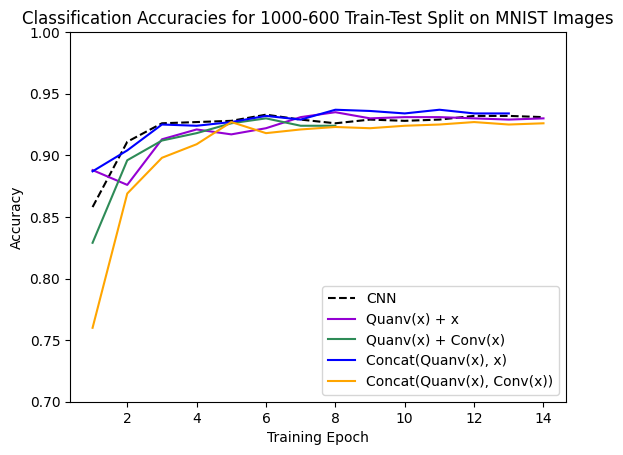

In [93]:
plt.title("Classification Accuracies for 1000-600 Train-Test Split on MNIST Images")
plt.xlabel("Training Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.plot(np.arange(1, len(cnn_accuracies)+1), np.array(cnn_accuracies) / 100, "--", c="black", label="CNN")
plt.plot(np.arange(1, len(qnn_accuracies_1)+1), qnn_accuracies_1 / 100, c="darkviolet", label="Quanv(x) + x")
plt.plot(np.arange(1, len(qnn_accuracies_2)+1), qnn_accuracies_2 / 100, c="seagreen", label="Quanv(x) + Conv(x)")
plt.plot(np.arange(1, len(qnn_accuracies_3)+1), qnn_accuracies_3 / 100, c="blue", label="Concat(Quanv(x), x)")
plt.plot(np.arange(1, len(qnn_accuracies_4)+1), qnn_accuracies_4 / 100, c="orange", label="Concat(Quanv(x), Conv(x))")
plt.legend()
plt.show()